# Appendix A

## Assignment 3: Build Non-Linear Models Part 1
Dawud Ujamaa  
School of Technology & Engineering, National University  
TIM-8555: Predictive Analysis  
Dr. Larry Fulton  
November 24, 2024 

### 2. Complete Applied Question 8 on page 286 of ISLR Python
In this exercise, we will generate simulated data, and will then use this data to perorm forward and backward selection.

#### (a) Create a random number generator and use its normal() method to generate a predictor X of length n=100, as well as a noise vector ϵ of length n = 100

In [1]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.api import OLS

import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split

from ISLP import load_data
from ISLP.models import ModelSpec as MS, summarize
from ISLP.models import \
     (Stepwise,
      sklearn_selected,
      sklearn_selection_path)

from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt

from functools import partial
from l0bnb import fit_path

import warnings
warnings.filterwarnings("ignore")

rng1 = np.random.default_rng(12345) # set seed for reproducibility
X = rng1.normal(size=100)

rng2 = np.random.default_rng(54321) # set seed for reproducibility
e = rng2.normal(size=100)

print("X:","\n", X,"\n","e:","\n",e)

X: 
 [-1.42382504e+00  1.26372846e+00 -8.70661738e-01 -2.59173235e-01
 -7.53433070e-02 -7.40884652e-01 -1.36779270e+00  6.48892802e-01
  3.61058113e-01 -1.95286306e+00  2.34740965e+00  9.68496906e-01
 -7.59387180e-01  9.02198274e-01 -4.66953173e-01 -6.06895187e-02
  7.88844345e-01 -1.25666813e+00  5.75857514e-01  1.39897899e+00
  1.32229806e+00 -2.99698515e-01  9.02919341e-01 -1.62158273e+00
 -1.58189261e-01  4.49483932e-01 -1.34360107e+00 -8.16875907e-02
  1.72473993e+00  2.61815943e+00  7.77361344e-01  8.28633196e-01
 -9.58988313e-01 -1.20938829e+00 -1.41229201e+00  5.41546830e-01
  7.51939396e-01 -6.58760320e-01 -1.22867499e+00  2.57557768e-01
  3.12902918e-01 -1.30811690e-01  1.26998312e+00 -9.29624577e-02
 -6.61508890e-02 -1.10821447e+00  1.35956851e-01  1.34707776e+00
  6.11440210e-02  7.09146003e-02  4.33654537e-01  2.77483660e-01
  5.30252387e-01  5.36720969e-01  6.18350015e-01 -7.95017456e-01
  3.00030946e-01 -1.60270159e+00  2.66798830e-01 -1.26162378e+00
 -7.12708062e-02  4.

#### (b) Generate a response vector Y of length n = 100 according to the model $Y={\beta}_{0} + {\beta}_{1}{X} + {\beta}_{2}{X}^{2} + {\beta}_{3}{X}^{3} + {\epsilon} $ where ${\beta}_{0}$, ${\beta}_{1}$, ${\beta}_{2}$, and ${\beta}_{3}$ are constants of your choice.

In [2]:
Y = 8 + 2*X + 4*(X**2) + 6*(X**3) + e
print("length Y:","\n", len(Y),"\n","Y:","\n",Y)

length Y: 
 100 
 Y: 
 [ -3.23263422  29.43210505   6.6959579    8.23289634   6.51054748
   7.21925271  -1.75604554  12.67883304  10.2057336  -26.19646787
 113.50879168  19.655207     6.03817094  19.26507782   7.45949229
   8.18604399  14.70770288   0.15966441  13.91074563  35.38852769
  32.13681449   8.2226553   18.05490763 -12.18239031   6.49028121
   8.83995429  -0.9140784    8.33252219  54.7763391  147.69964644
  14.82377451  15.21369974   4.09133152  -0.75145754  -2.77440571
  10.78390096  13.36590292   7.01133009  -1.34257786   8.59884268
   8.26801621   6.48721324  31.08355572   6.38552735   9.14823459
   2.29062679   7.6180704   33.1498517    8.15757001   8.11124798
  10.4134489    8.91849724  11.36046711  11.83147131  10.67798037
   6.7945463    9.02631336  -9.7649237    7.90159642  -0.93524569
   6.53542685  11.23686773   6.62492286   8.40697777 -12.92523442
   5.62093746  13.21729762   0.63732459  12.89832984  -2.0855174
   4.74868046   3.22858239   6.89606475  11.27694235  

#### (c) Use forward stepwise selection in order to select a model containing the predictors ${X}$, ${X}^{2}$,...${X}^{10}$. What is the model obtained according to ${C}_{p}$? Report the coefficients of the model obtained.

In [3]:
# uses function for Cp from ISLP page 268
def nCp(sigma2 , estimator , X, Y):
    "Negative Cp statistic"
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / n

In [4]:
# make data frame with predictors X1 to X10
X_df = pd.DataFrame({'X1': X, 'X2': X**2, 'X3': X**3, 'X4': X**4, 'X5': X**5,
                  'X6': X**6, 'X7': X**7, 'X8': X**8, 'X9': X**9, 'X10': X**10})

# make data frame for response variable Y
Y_df = pd.DataFrame({'Y': Y})

# calculate sigma2
design = MS(X_df).fit(X_df)
y = np.array(Y_df['Y'])
x = design.transform(X_df)
sigma2 = OLS(y,x).fit().scale

# calculate neg_Cp as a scorer for forward selection model selection
neg_Cp = partial(nCp , sigma2)

# run forward stepwise selection
strategy = Stepwise.first_peak(design, direction='forward', max_terms=len(design.terms))

# fit linear regression model
Y_Cp = sklearn_selected(OLS,strategy,scoring=neg_Cp)
Y_Cp.fit(x, y)

Y_Cp.selected_state_

('X1', 'X10', 'X2', 'X3')

In [5]:
# build model with features selected from forward stepwise selection to find coefficients
X_mod = X_df[['X1', 'X10', 'X2', 'X3']]

# add constant for intercept
X_mod = sm.add_constant(X_mod)

#fit linear regression model
model1 = sm.OLS(Y_df, X_mod).fit()

#view model summary
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 1.272e+04
Date:                Sat, 23 Nov 2024   Prob (F-statistic):          1.06e-128
Time:                        13:10:22   Log-Likelihood:                -129.34
No. Observations:                 100   AIC:                             268.7
Df Residuals:                      95   BIC:                             281.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.8480      0.124     63.266      0.0

#### (d) Repeat (c) using backwards stepwise seletion. How does your answer compare to the results in (c)?

In [6]:
# calculate neg_Cp2 as a scorer for forward selection model selection
neg_Cp2 = partial(nCp , sigma2) 

# run backwards stepwise selection
strategy2 = Stepwise.first_peak(design, direction='backwards', max_terms=len(design.terms))

# fit linear regression model
Y_Cp2= sklearn_selected(OLS,strategy2,scoring=neg_Cp2)
Y_Cp2.fit(x, y)

Y_Cp2.selected_state_

('X1', 'X10', 'X2', 'X3')

#### (e) Now fit a lasso model to the simulated data, again using ${X}$, ${X}^{2}$,...${X}^{10}$ as predictors. Use cross-validation to select the optimal value of ${\lambda}$. Create plots of the cross-validation error as a function of ${\lambda}$. Report the resulting coefficent estimates, and discuss the results obtained.

In [7]:
# set K = 10 for cross-validation
K = 10
kfold = skm.KFold(K, random_state=0, shuffle=True)

# define scaler
scaler = StandardScaler(with_mean=True , with_std=True)

# define X array for Lasso
D = design.fit_transform(X_df)
D = D.drop('intercept', axis=1)
X_lasso = np.asarray(D)

# Fit Lasso model using cross-validation to select optimal lambda value
lassoCV = skl.ElasticNetCV(n_alphas=100, l1_ratio=1, cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler), ('lasso', lassoCV)])
pipeCV.fit(X_lasso, y)
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_

0.06560977272246735

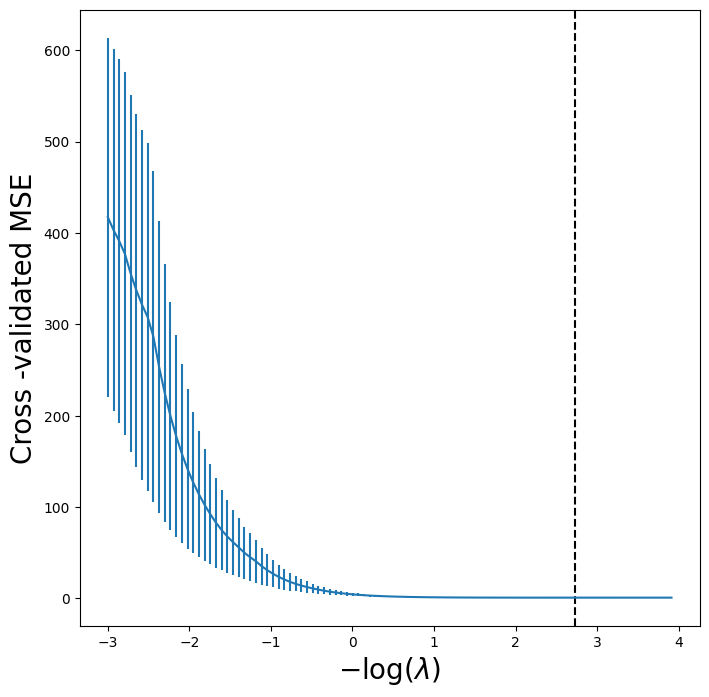

In [8]:
# plot cross-validation error as a function of lambda
lassoCV_fig , ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(tuned_lasso.alphas_),tuned_lasso.mse_path_.mean(1),yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross -validated MSE', fontsize=20);

In [9]:
# Report the resulting coefficent estimates
tuned_lasso.coef_

array([ 2.03737929,  4.51218581, 16.68850862,  0.        ,  0.        ,
        0.        ,  0.        , -0.        ,  0.        , -0.        ])

In [10]:
#print regression coefficients
pd.DataFrame(zip(X_df.columns, tuned_lasso.coef_))

,0,1
0,X1,2.037379
1,X2,4.512186
2,X3,16.688509
3,X4,0.000000
4,X5,0.000000
5,X6,0.000000
6,X7,0.000000
7,X8,-0.000000
8,X9,0.000000
9,X10,-0.000000


#### (f) Now generate a response vector Y according to the model $Y={\beta}_{0} + {\beta}_{7}{X}^{7} + {\epsilon} $ and perform forward stepwise selection and the lasso. Discuss the results obtained..

In [11]:
Y2 = 8 + 7*(X**7) + e
print("length Y2:","\n", len(Y2),"\n","Y:","\n",Y2)

length Y2: 
 100 
 Y: 
 [-7.42165154e+01  4.44383317e+01  6.71023835e+00  8.58646311e+00
  6.64109371e+00  8.08772280e+00 -5.38462475e+01  8.39654098e+00
  8.68535326e+00 -7.51089265e+02  2.75845066e+03  1.41104621e+01
  6.85836834e+00  1.32044491e+01  8.09823384e+00  8.29403133e+00
  9.02621057e+00 -2.63816999e+01  1.04338112e+01  8.17475744e+01
  5.81033454e+01  8.62276745e+00  1.19961569e+01 -2.00255341e+02
  6.73029803e+00  6.61391972e+00 -4.62283970e+01  8.47247629e+00
  3.26451092e+02  5.91033430e+03  9.23414267e+00  9.27383535e+00
  2.40087339e+00 -2.00584677e+01 -6.94723915e+01  7.67040946e+00
  8.00086785e+00  7.93139556e+00 -2.33854696e+01  7.71639730e+00
  7.06881852e+00  6.69381570e+00  4.71001930e+01  6.54170407e+00
  9.26476940e+00 -6.60951504e+00  7.25714727e+00  6.48745038e+01
  8.01895607e+00  7.94716359e+00  8.32479466e+00  7.92823510e+00
  8.36325751e+00  8.76788720e+00  6.73522887e+00  7.46613920e+00
  7.90565906e+00 -1.82270466e+02  6.96999884e+00 -2.83429391e+01
 

In [12]:
# Run forward stepwise selection

# make data frame for response variable Y2
Y2_df = pd.DataFrame({'Y': Y2})

# calculate sigma2
design = MS(X_df).fit(X_df)
y2 = np.array(Y2_df['Y'])
x = design.transform(X_df)
sigma2 = OLS(y2,x).fit().scale

# calculate neg_Cp as a scorer for forward selection model selection
neg_Cp = partial(nCp , sigma2)

# run forward stepwise selection
strategy = Stepwise.first_peak(design, direction='forward', max_terms=len(design.terms))

# fit linear regression model
Y2_Cp = sklearn_selected(OLS,strategy,scoring=neg_Cp)
Y2_Cp.fit(x, y2)

Y2_Cp.selected_state_

('X3', 'X7')

In [13]:
# build model with features selected from forward stepwise selection to find coefficients
X_mod2 = X_df[['X3', 'X7']]

# add constant for intercept
X_mod2 = sm.add_constant(X_mod2)

#fit linear regression model
model2 = sm.OLS(Y2_df, X_mod2).fit()

#view model summary
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.630e+07
Date:                Sat, 23 Nov 2024   Prob (F-statistic):          7.70e-279
Time:                        13:10:23   Log-Likelihood:                -130.25
No. Observations:                 100   AIC:                             266.5
Df Residuals:                      97   BIC:                             274.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.9454      0.092     86.395      0.0

In [14]:
# Perform the Lasso

# Fit Lasso model using cross-validation to select optimal lambda value
lassoCV = skl.ElasticNetCV(n_alphas=100, l1_ratio=1, cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler), ('lasso', lassoCV)])
pipeCV.fit(X_lasso, y2)
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_

0.6554940131129722

In [15]:
tuned_lasso.coef_

array([ -3.96154566,   0.        ,  -0.        ,   0.        ,
        96.80460189,   7.25926444, 426.78904016,   0.        ,
       128.55728201,   0.        ])

In [16]:
#print regression coefficients
pd.DataFrame(zip(X_df.columns, tuned_lasso.coef_))

,0,1
0,X1,-3.961546
1,X2,0.000000
2,X3,-0.000000
3,X4,0.000000
4,X5,96.804602
5,X6,7.259264
6,X7,426.789040
7,X8,0.000000
8,X9,128.557282
9,X10,0.000000


### 3. Continue competing in the Regression with Abalone Dataset competition (late submission) on Kaggle.com
https://www.kaggle.com/competitions/playground-series-s4e4
Build one model using regularization techniques to inform your best subset selection.  
Build one model using principal components regression.  
Interpret your regression models, investigate assumptions, and interpret all findings.

#### EDA, Preprocessing, and Feature Engineering
The EDA conducted on the data set in week 2 revealed the need for certain data preprocessing and feature engineering steps that will be performed. 1) variables will be renamed to not contain blank character spaces; 2) the distribution of response variable was skewed, so the data will be transformed with the transformation $\sqrt{x+1}$; and 3) Dummy variables will be created for the qualitative Sex variable.

In [17]:
# import training data
AbaloneTrain = pd.read_csv(r'./train.csv',index_col=0)

# rename variables
AbaloneTrain.rename(columns={"Whole weight":"Whole_weight","Whole weight.1":"Whole_weight1",
                            "Whole weight.2":"Whole_weight2","Shell weight":"Shell_weight"},inplace=True)

# Create new square root transformed features
AbaloneTrain['Length_Trans'] = np.sqrt(AbaloneTrain['Length']+1)
AbaloneTrain['Diameter_Trans'] = np.sqrt(AbaloneTrain['Diameter']+1)
AbaloneTrain['Height_Trans'] = np.sqrt(AbaloneTrain['Height']+1)
AbaloneTrain['Whole_weight_Trans'] = np.sqrt(AbaloneTrain['Whole_weight']+1)
AbaloneTrain['Whole_weight1_Trans'] = np.sqrt(AbaloneTrain['Whole_weight1']+1)
AbaloneTrain['Whole_weight2_Trans'] = np.sqrt(AbaloneTrain['Whole_weight2']+1)
AbaloneTrain['Shell_weight_Trans'] = np.sqrt(AbaloneTrain['Shell_weight']+1)
AbaloneTrain['Rings_Trans'] = np.sqrt(AbaloneTrain['Rings']+1)

# Generate dummy variables for sex
AbaloneTrain = pd.get_dummies(AbaloneTrain,columns=['Sex'])
AbaloneTrain

,Length,Diameter,Height,Whole_weight,Whole_weight1,Whole_weight2,Shell_weight,Rings,Length_Trans,Diameter_Trans,Height_Trans,Whole_weight_Trans,Whole_weight1_Trans,Whole_weight2_Trans,Shell_weight_Trans,Rings_Trans,Sex_F,Sex_I,Sex_M
id,,,,,,,,,,,,,,,,,,,
0,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11,1.244990,1.195826,1.072381,1.330977,1.152606,1.070747,1.113553,3.464102,1,0,0
1,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11,1.276715,1.220656,1.070047,1.459452,1.207477,1.129823,1.148913,3.464102,1,0,0
2,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6,1.077033,1.053565,1.012423,1.010445,1.002746,1.001499,1.002497,2.645751,0,1,0
3,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10,1.262933,1.214496,1.072381,1.383655,1.172817,1.097953,1.118034,3.316625,0,0,1
4,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9,1.246996,1.193734,1.063015,1.334916,1.170256,1.077033,1.094303,3.162278,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90610,0.335,0.235,0.075,0.1585,0.0685,0.0370,0.0450,6,1.155422,1.111306,1.036822,1.076336,1.033683,1.018332,1.022252,2.645751,0,0,1
90611,0.555,0.425,0.150,0.8790,0.3865,0.1815,0.2400,9,1.246996,1.193734,1.072381,1.370766,1.177497,1.086968,1.113553,3.162278,0,0,1
90612,0.435,0.330,0.095,0.3215,0.1510,0.0785,0.0815,6,1.197915,1.153256,1.046422,1.149565,1.072847,1.038509,1.039952,2.645751,0,1,0


#### Abalone Regression Model 3 - use LASSO Regularization method to inform subset selection

In [18]:
# specify response and predictor variables
y = AbaloneTrain['Rings_Trans'] 

# since the dependent variables will be standardized for modeling, 
# the features without the square root transformation will be used
x = AbaloneTrain[['Length','Diameter','Height','Whole_weight','Whole_weight1',
                  'Whole_weight2','Shell_weight','Sex_F','Sex_M']]

# set K = 10 for cross-validation
K = 10
kfold = skm.KFold(K, random_state=0, shuffle=True)

# define scaler
scaler = StandardScaler(with_mean=True , with_std=True)

# define X array for Lasso
design = MS(x).fit(x)
D = design.fit_transform(x)
D = D.drop('intercept', axis=1)
X_lasso = np.asarray(D)

# Fit Lasso model using cross-validation to select optimal lambda value
lassoCV = skl.ElasticNetCV(n_alphas=100, l1_ratio=1, cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler), ('lasso', lassoCV)])
pipeCV.fit(X_lasso, y)
model3_tuned_lasso = pipeCV.named_steps['lasso']
model3_tuned_lasso.alpha_

0.00033699837522140926

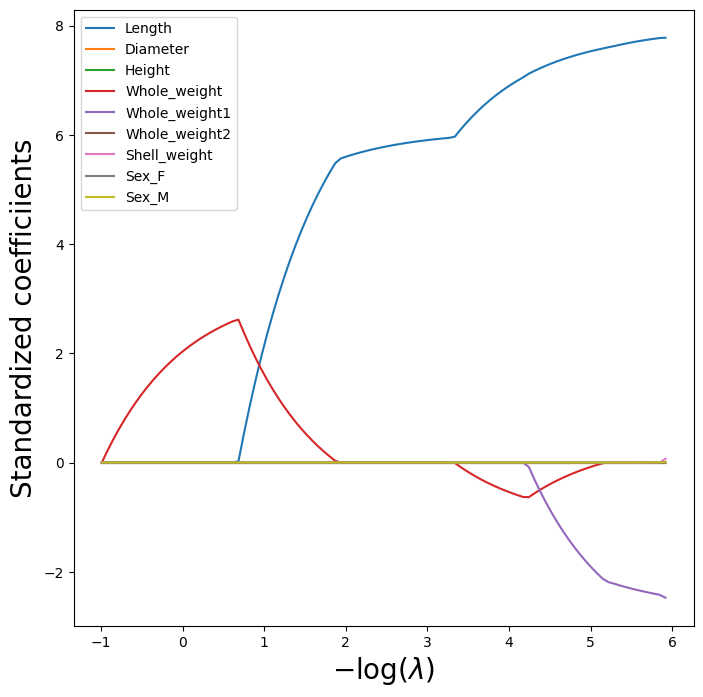

In [19]:
# plot standardized coefficients as a function of lambda
lambdas , soln_array = skl.Lasso.path(X_lasso, y, l1_ratio=1, n_alphas =100)[:2]
soln_path = pd.DataFrame(soln_array.T, columns=D.columns , index=-np.log(lambdas))

path_fig , ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.legend(loc='upper left')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficiients', fontsize=20);

In [20]:
# Report the resulting coefficent estimates
model3_tuned_lasso.coef_

array([ 0.00564832,  0.14361868,  0.12233048,  0.17302788, -0.43215812,
       -0.08176371,  0.35932134,  0.0493256 ,  0.0506883 ])

In [21]:
#print regression coefficients
pd.DataFrame(zip(x.columns, model3_tuned_lasso.coef_))

,0,1
0,Length,0.005648
1,Diameter,0.143619
2,Height,0.122330
3,Whole_weight,0.173028
4,Whole_weight1,-0.432158
5,Whole_weight2,-0.081764
6,Shell_weight,0.359321
7,Sex_F,0.049326
8,Sex_M,0.050688


In [22]:
# Evaluate the model's performance
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.metrics import mean_absolute_error as MAE 
from sklearn.metrics import mean_squared_error as MSE 
from sklearn.metrics import mean_absolute_percentage_error as MAPE 
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score

def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

def myf(y,yhat): 
    r2 = r2_score(y, yhat)
    ME=np.round(np.mean(y-yhat),3)
    MPE=np.round(np.mean((y-yhat)/y),3) 
    myMAE=np.round(MAE(y,yhat),3) 
    myMSE=np.round(MSE(y,yhat),3) 
    myMAPE=np.round(MAPE(y,yhat),3) 
    myRMSLE=np.round(rmsle(y,yhat),3) 
    print("\n","R-squared:", np.round(r2,3),"\n","ME:", np.round(ME,3),"\n","MPE:",MPE,"\n", "MAE:", myMAE,
          "\n", "MSE:", myMSE,"\n","MAPE:",myMAPE,"\n","RMSLE:",myRMSLE) 

# Get the fitted values
y_pred = model3_tuned_lasso.predict(X_lasso)  

myf(y, y_pred) 


 R-squared: 0.097 
 ME: -0.166 
 MPE: -0.07 
 MAE: 0.356 
 MSE: 0.197 
 MAPE: 0.117 
 RMSLE: 0.106


##### Assess residuals of model 3 to investigate assumptions

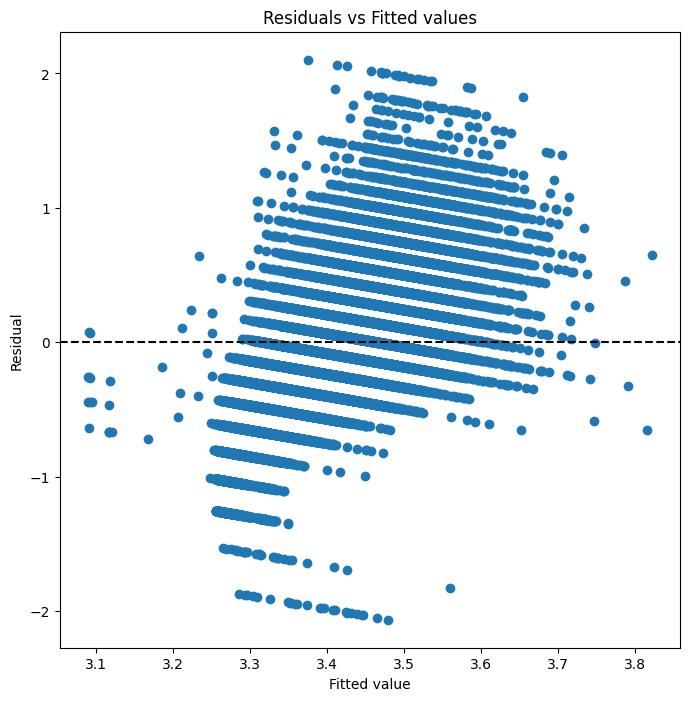

In [23]:
# Get the residuals
residuals = y - y_pred

# scatter plot of residuals vs fitted values to assess homoscedasticity
ax = plt.subplots(figsize=(8,8))[1]
ax.scatter(y_pred , residuals)
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.set_title('Residuals vs Fitted values')
ax.axhline(0, c='k', ls='--');

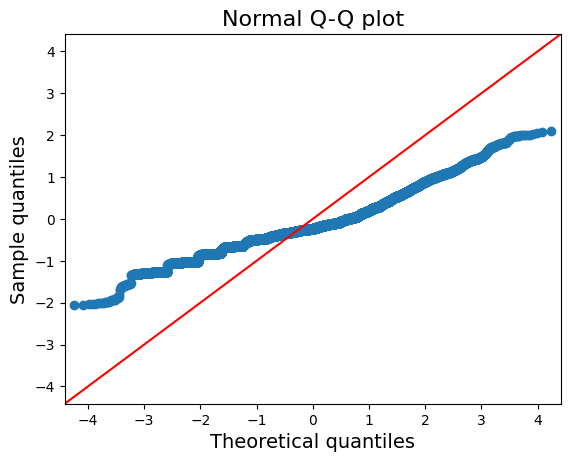

In [24]:
# Normal Q-Q Plot of Residuals to assess normality of residuals
resid = np.ravel(residuals)
p = sm.qqplot(resid, line='45')
plt.title('Normal Q-Q plot', fontsize=16);
plt.xlabel('Theoretical quantiles', fontsize=14);
plt.ylabel('Sample quantiles', fontsize=14);

In [25]:
# calculate VIF to assess multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif["features"] = x.columns
print(vif)

   VIF Factor       features
0  901.832568         Length
1  965.736533       Diameter
2  103.747704         Height
3  270.785650   Whole_weight
4   80.419058  Whole_weight1
5   76.299563  Whole_weight2
6   71.818069   Shell_weight
7    2.956600          Sex_F
8    3.015515          Sex_M


#### Abalone Regression Model 4 - use principal components regression

In [26]:
pca = PCA(n_components=2)
linreg = skl.LinearRegression()
model4_pca_pipe = Pipeline([('scaler', scaler), ('pca', pca), ('linreg', linreg)])
model4_pca_pipe.fit(x, y)
model4_pca_pipe.named_steps['linreg'].coef_

array([ 0.1228247 , -0.00069758])

In [27]:
#print regression coefficients
pd.DataFrame(zip(x.columns, model4_pca_pipe.named_steps['linreg'].coef_))

,0,1
0,Length,0.122825
1,Diameter,-0.000698


In [28]:
param_grid = {'pca__n_components': range(1, 9)}
grid = skm.GridSearchCV(model4_pca_pipe , param_grid , cv=kfold , scoring='neg_mean_squared_error')
grid.fit(x, y)

GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=2)),
                                       ('linreg', LinearRegression())]),
             param_grid={'pca__n_components': range(1, 9)},
             scoring='neg_mean_squared_error')

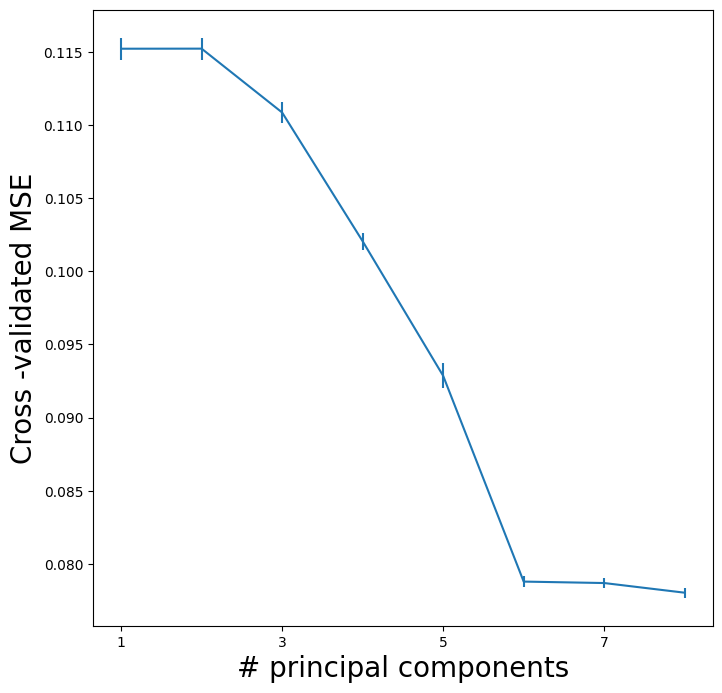

In [29]:
# plot the results
pcr_fig , ax = subplots(figsize=(8,8))
n_comp = param_grid['pca__n_components']
ax.errorbar(n_comp , -grid.cv_results_['mean_test_score'], grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylabel('Cross -validated MSE', fontsize=20)
ax.set_xlabel('# principal components', fontsize=20)
ax.set_xticks(n_comp [::2]);

In [30]:
model4_pca_pipe.named_steps['pca'].explained_variance_ratio_

array([0.7562398 , 0.16247835])

In [31]:
# Get the fitted values
y_pred = model4_pca_pipe.predict(x)  

# Evaluate the model
myf(y, y_pred) 


 R-squared: 0.471 
 ME: 0.0 
 MPE: -0.01 
 MAE: 0.246 
 MSE: 0.115 
 MAPE: 0.073 
 RMSLE: 0.076


##### Assess residuals of model 3 to investigate assumptions

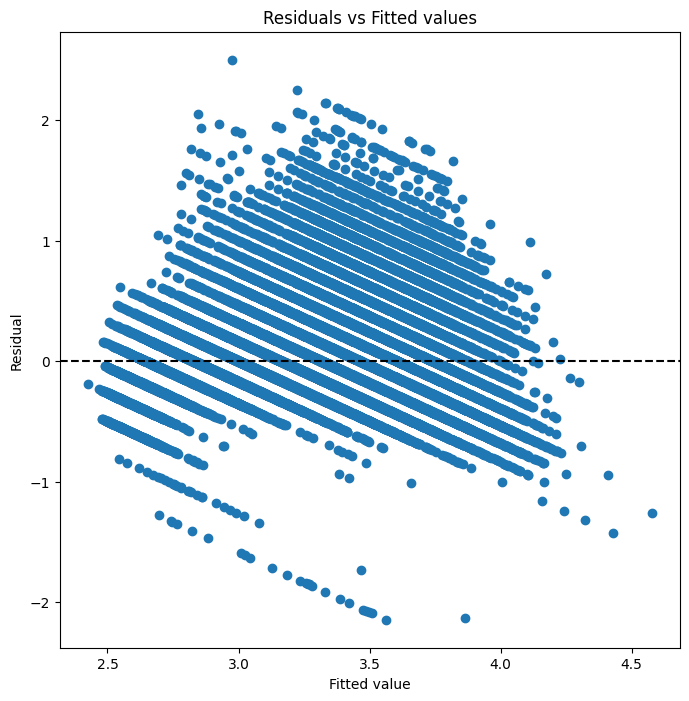

In [32]:
# Get the residuals
residuals = y - y_pred

# scatter plot of residuals vs fitted values to assess homoscedasticity
ax = plt.subplots(figsize=(8,8))[1]
ax.scatter(y_pred , residuals)
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.set_title('Residuals vs Fitted values')
ax.axhline(0, c='k', ls='--');

In [ ]:
# Normal Q-Q Plot of Residuals to assess normality of residuals
resid = np.ravel(residuals)
p = sm.qqplot(resid, line='45')
plt.title('Normal Q-Q plot', fontsize=16);
plt.xlabel('Theoretical quantiles', fontsize=14);
plt.ylabel('Sample quantiles', fontsize=14);

In [ ]:
# calculate VIF to assess multicollinearity
x_pcr = x[['Length','Diameter']]

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x_pcr.values, i) for i in range(x_pcr.shape[1])]
vif["features"] = x_pcr.columns
print(vif)

#### Generate predictions on the test data

In [ ]:
# import test data
AbaloneTest = pd.read_csv(r'./test.csv')

# rename variables
AbaloneTest.rename(columns={"Whole weight":"Whole_weight","Whole weight.1":"Whole_weight1",
                            "Whole weight.2":"Whole_weight2","Shell weight":"Shell_weight"},inplace=True)

# transform test data and Generate dummy variables for sex
AbaloneTest['Length_Trans'] = np.sqrt(AbaloneTest['Length']+1)
AbaloneTest['Diameter_Trans'] = np.sqrt(AbaloneTest['Diameter']+1)
AbaloneTest['Height_Trans'] = np.sqrt(AbaloneTest['Height']+1)
AbaloneTest['Whole_weight_Trans'] = np.sqrt(AbaloneTest['Whole_weight']+1)
AbaloneTest['Whole_weight1_Trans'] = np.sqrt(AbaloneTest['Whole_weight1']+1)
AbaloneTest['Whole_weight2_Trans'] = np.sqrt(AbaloneTest['Whole_weight2']+1)
AbaloneTest['Shell_weight_Trans'] = np.sqrt(AbaloneTest['Shell_weight']+1)

AbaloneTest = pd.get_dummies(AbaloneTest,columns=['Sex'])
AbaloneTest

In [ ]:
# Model3 Predict on the test data

# specify response variables
x = AbaloneTest[['Length','Diameter','Height','Whole_weight','Whole_weight1',
                  'Whole_weight2','Shell_weight','Sex_F','Sex_M']]

# define X array for Lasso
design = MS(x).fit(x)
D = design.fit_transform(x)
D = D.drop('intercept', axis=1)
X_lasso = np.asarray(D)

# Get the predicted values
y_pred3 = model3_tuned_lasso.predict(X_lasso) 

# use back-transfomration to get predicted rings
Output3 = AbaloneTest
Output3['Rings'] = np.round((np.square(y_pred3) - 1), 0)
Output3

In [ ]:
# generate output for submission for Model3
Submission3 = Output3[['id','Rings']]
Submission3.to_csv(r'LASSO_AbaloneRegressionSubmission3.csv', index = False)
Submission3

In [ ]:
# Model4 Predict on the test data

# Get the predicted values
y_pred4 = model4_pca_pipe.predict(x)  

# use back-transfomration to get predicted rings
Output4 = AbaloneTest
Output4['Rings'] = np.round((np.square(y_pred4) - 1), 0)
Output4

In [ ]:
# generate output for submission for Model4
Submission4 = Output4[['id','Rings']]
Submission4.to_csv(r'PCR_AbaloneRegressionSubmission4.csv', index = False)
Submission4

In [ ]:
# Print Python version
import sys
print(sys.version)

# Print Jupyter notebook version
import notebook
notebook.__version__

In [ ]:
!jupyter --version